<br>

# Eye Keypoint Detector
---
<br>

## 딥러닝 모델을 이용한 키포인트 검출 <br><br>

기존 키포인트 검출 모델보다 더 좋은 성능을 만들기 위해 <br>
딥러닝 모델을 이용한 키포인트 검출을 시도

<br>

<br>

## 데이터 준비 <br><br>


학습에 필요한 데이터셋이 충분히 많으면 상관 없지만, <br>
데이터셋이 부족할 경우 직접 데이터셋을 생성해야할 때도 있습니다. <br><br>

이 때, 수 많은 데이터셋을 자동으로 생성하기 위해 <br>
필요한 데이터셋에 따라 여러가지 방법이 사용됩니다. <br><br><br>



### Data Annotation <br><br>


눈동자 검출 모델을 생성하기 위해서 대량의 '눈동자 위치 라벨' 이 필요 <br>
( 성능 확인을 위해서는 10000 개 이상 필요 ) <br><br>

LFW 데이터셋에 눈동자 라벨링을 위한 어노테이션 함수를 적용하여 <br>
필요한 데이터셋을 대량으로 생성해 봅시다. <br>
( 여기서는 ```prepare_eye_dataset.py``` 를 실행하여 어노테이션된 데이터셋 생성 )

<br>

In [1]:
# 모듈 임포트

import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

<br>

TensorFlow Hub에서 제공하는 pretrained image feature embedding 을 이용하여 fine tuning <br><br>

데이터를 케라스 ImageDataGenerator 형식으로 읽기 <br>
( 여기서는 라벨이 image 형태로 저장되 있습니다 )

<br>

In [2]:
# 어노테이션된 (이미지)데이터를 불러와 학습을 위한 데이터 준비

import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23680 23680
Found 23680 images belonging to 1 classes.
Found 23680 images belonging to 1 classes.


<br>

### Dataset generator <br><br>

모델 학습을 위한 데이터셋을 생성하는 함수를 작성 <br><br>

image_generator 와 label generator 를 학습할 수 있는 입출력 형식으로 편집 <br>
텐서플로우의 제너레이터(generator) 형식을 사용하고 있기 때문에 출력 형식도 맞추어 주기 <br><br>

참고. <br>
[제네레이터](https://tensorflow.blog/%ED%9A%8C%EC%98%A4%EB%A6%AC%EB%B0%94%EB%9E%8C%EC%9D%84-%ED%83%84-%ED%8C%8C%EC%9D%B4%EC%8D%AC/%EC%A0%9C%EB%84%88%EB%A0%88%EC%9D%B4%ED%84%B0/)

<br>

In [3]:
# 모델 학습을 위한 데이터셋 생성하는 함수 작성

def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [4]:
# 생성한 user_generation 제네레이터 함수로 데이터 포인트를 뽑아 확인
# 120x80의 정해진 크기로 이미지가 잘 출력되고 라벨 또한 0~1 갑ㅅ으로 정규화(normalize) 되어 있는 것을 확인

user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.     0.     1.     1.     0.6375 0.4   ]
(80, 120, 3) [0.         0.         1.         1.         0.06666667 0.3330357 ]
/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.


<br>

## 모델 설계 : Keypoint 검출 딥러닝 모델 만들기 <br><br>


데이터가 부족하므로 '미리 학습된 모델' 을 적극 활용 <br>

- TensorFlow Hub 에서 ResNet 의 feature Extraction (특성추출) 부분을 백본(backbone) 모델로 사용 <br>

- ```tf.keras.Sequential()``` 을 이용해 <br>
backbone 네트워크 + fully connected layer 의 형태로 레이어를 추가로 쌓아 쉽게 모델을 완성 <br><br><br>



- 데이터 제네레이터에서 출력을 (x,y)좌표 2개 * 점 3개 인 6개로 정했기 때문에, <br>
```num_classes = 6``` 으로 설정 <br><br>

- 이 문제는 점을 맞는 위치로 추정하는 position regression 문제이기 때문에 <br>
loss와 metric을 각각 mse 와 mae 로 설정 <br>
( mae 를 통해서 픽셀 위치가 평균적으로 얼마나 차이나는지 확인하면서 학습할 수 있습니다 )

<br>

In [5]:
# 모델 생성 후 확인

''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Lay

In [6]:
# 모델 컴파일

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [7]:
# learning rate 조절하는 함수 작성 (지수적으로 감소하도록)

def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

In [8]:
# 모델 학습

steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23680 32 740
Epoch 1/10
/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
740/740 [==============================] - 25s 30ms/step - loss: 0.0282 - mae: 0.0867
Epoch 2/10
740/740 [==============================] - 18s 25ms/step - loss: 0.0144 - mae: 0.0563
Epoch 3/10
740/740 [==============================] - 19s 25ms/step - loss: 0.0136 - mae: 0.0542
Epoch 4/10
740/740 [==============================] - 18s 25ms/step - loss: 0.0133 - mae: 0.0534
Epoch 5/10
740/740 [==============================] - 18s 25ms/step - loss: 0.0129 - mae: 0.0525
Epoch 6/10
740/740 [==============================] - 19s 25ms/step - loss: 0.0129 - mae: 0.0522
Epoch 7/10
740/740 [==============================] - 18s 24ms/step - loss: 0.0129 - mae: 0.0524
Epoch 8/10
740/740 [========

<br>

## 모델 학습 결과 평가 <br><br>

검증(validation)용 데이터는 섞어줄(shuffle) 필요가 없기 때문에 <br>
```shuffle=False``` 옵션을 추가

<br>

<br>

### 모델 평가 <br><br>


평가용 데이터셋 전체(?)에 대하여 <br>
정답(label) 과 예측값(label) 의 잔차들의 평균(MSE, MAE)을 통해 모델을 평가 <br><br>

tf.keras.Model.evaluate_generator() 메소드 사용 <br>
```
evaluate_generator(
    generator, steps=None, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=0
)
```

<br>

In [9]:
# 검증용 데이터셋 준비

IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2638 images belonging to 1 classes.
Found 2638 images belonging to 1 classes.


In [10]:
# 위에서 작성한 user_val_generator 함수로 평가용 모델에 입력으로 들어갈 데이터셋 준비

user_val_generator = user_generation(image_data_val, label_data_val)

In [11]:
# 모델 평가 (정답 label 과 predict label 의 잔차 계산)

# MSE (Mean Sqaured Error), MAE (Mean Absolute Error) 로 계산
# 평균 에러가 0.026 정도 (우리가 찍은 점들은 120 픽셀을 기준으로 120*0.026 = 3.12 픽셀 정도 에러가 나는 것을 확인할 수 있습니다)

mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/home/ssac29/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
0.012543492019176483 0.05144177004694939


<br>

### 모델 테스트 <br><br>


테스트용 모델 1장에 대해 <br>
위에서 학습하고 평가 확인한 모델을 적용하여 eye key detection 수행 <br><br>


- 입력을 위해 이미지를 120x80 으로 resize 한 후, <br>
    배치(batch)를 나타낼 수 있는 4차원 텐서로 변경 <br><br>

- 이미지 1장에 대한 출력을 위해 <br>
    배치 크기(batch size)를 1 로 설정

<br>

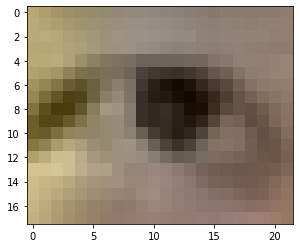

In [12]:
# img test : 실제 이미지에 출력하여 확인

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_000010_l.png')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
# 테스트하고자 하는 이미지에 모델을 적용하기 위해, 모델 입력에 맞는 크기로 이미지 리사이즈 적용
# 위에서 학습한 keypoint detection 모델로 눈동자 위치의 점 예측 수행

np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80

# 출력 결과는 1행부터 좌측, 우측, 중앙 좌표를 나타냄
print (repred)

[[[2.8020787e-04 8.9076872e-04]
  [1.1999970e+02 7.9999893e+01]
  [4.1624363e+01 2.9241312e+01]]]


[0. 0.]
[120.  80.]
[42. 29.]


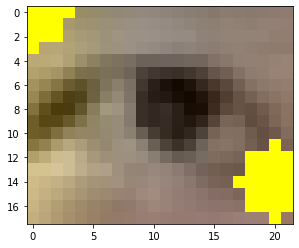

In [14]:
# 결과를 이미지로 출력 (시각화)

show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

<br>

눈의 왼쪽은 정말 잘 찾은 것 같은 반면, 눈 중심과 오른쪽 위치는 5픽셀 정도의 오차를 보이는 것 같습니다. <br>
더 정확한 성능(적은 에러)를 원한다면 데이터를 추가로 넣어야 할 것 같습니다.

<br>

<br>

## 프로젝트 : 카메라 앱에 표정효과 적용 <br><br>

위에서 만든 eye keypoint detection 모델을 이용하여 눈의 위치 좌표를 찾고, <br>
해당 위치에 스티커 붙이기 효과를 적용해 봅시다. (당황한 표정의 눈 이미지를 준비하여 원본 얼굴 이미지에 합성)

<br>